In [31]:
import holodeck as holo
from holodeck import single_sources, utils, plot, detstats
from holodeck.constants import YR

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt

import hasasia.sensitivity as hsen
import hasasia.sim as hsim
import hasasia.skymap as hsky

# Read in saved sam & strain data

Option 1) Make realizations

In [91]:
dur = 15 * YR
nfreqs = 40
cad = dur/nfreqs/2
fobs= utils.nyquist_freqs(dur, cad)
fobs_edges = utils.nyquist_freqs_edges(dur, cad)
df_orb = np.diff(fobs_edges/2)
print(len(fobs))
sam = holo.sam.Semi_Analytic_Model()
hc_ss, hc_bg = sam.ss_gwb(fobs_edges, realize=3, loudest=10000)
np.savez('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/npz_arrays/sam02_r3_f40_l10000.npz', 
         dur=dur, cad=cad, fobs=fobs, df_orb=df_orb, hc_ss=hc_ss, hc_bg=hc_bg)

40
17:28:55 INFO : zero_coalesced=True, zero_stalled=False [sam.py:dynamic_binary_number]
17:28:55 INFO : Stalled SAM bins based on GMT: 2.58e+05/6.53e+05 = 3.96e-01 [sam.py:static_binary_density]
17:28:55 INFO : Adding MMbulge scatter (3.4000e-01) [sam.py:static_binary_density]
17:28:55 INFO : 	dens bef: (0.00e+00, 0.00e+00, 3.29e-61, 8.58e-04, 1.48e-02, 2.79e-02, 4.47e-02) [sam.py:static_binary_density]
17:29:11 INFO : Scatter added after 15.402369 sec [sam.py:static_binary_density]
17:29:11 INFO : 	dens aft: (6.72e-29, 2.61e-15, 3.78e-09, 1.03e-03, 1.50e-02, 2.80e-02, 4.26e-02) [sam.py:static_binary_density]
17:29:11 INFO : 	mass: 8.56e-02 ==> 8.54e-02 || change = -1.7939e-03 [sam.py:static_binary_density]
17:29:11 INFO : zeroing out 2.58e+05/6.53e+05 = 3.96e-01 systems stalled from GMT [sam.py:static_binary_density]
17:29:12 INFO : fraction of coalesced binaries: 3.64e+06/2.61e+07 = 1.40e-01 [sam.py:dynamic_binary_number]
17:29:12 INFO : stalled binaries are not being accounted for

Option 2) Load existing

In [92]:
hcfile = np.load('/Users/emigardiner/GWs/holodeck/ecg-notebooks/detstats_functions/npz_arrays/sam02_r3_f40_l10000.npz')
dur = hcfile['dur']
cad = hcfile['cad']
fobs = hcfile['fobs'][:]
df_orb = hcfile['df_orb']
hc_ss = hcfile['hc_ss']
hc_bg = hcfile['hc_bg']
hcfile.close()

shape = hc_ss.shape
F, R, L = shape[0], shape[1], shape[2]
print('F, R, L =', F,R,L)

F, R, L = 40 3 10000


# Healpy Tutorial

In [4]:
# Random sky positions
NSIDE = 32
print( "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60))
NPIX = hp.nside2npix(NSIDE)
print(NPIX)

Approximate resolution at NSIDE 32 is 1.8 deg
12288


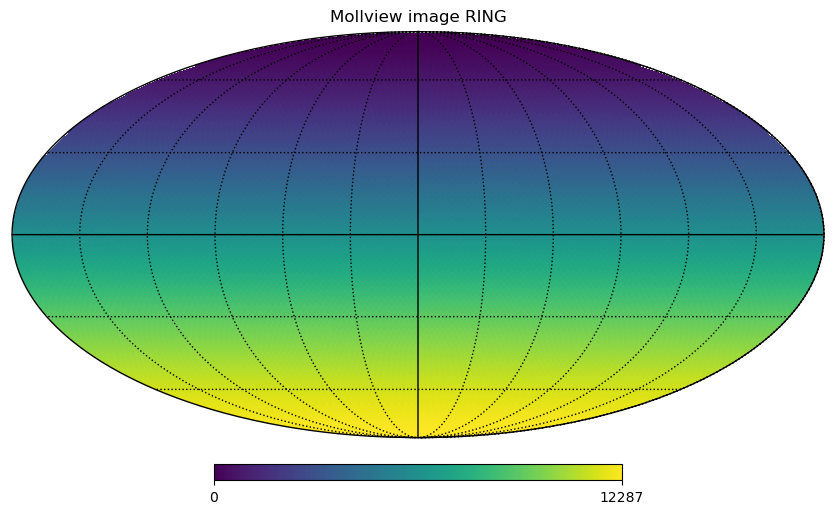

In [6]:
m = np.arange(NPIX) # value at each pixel
hp.mollview(m, title="Mollview image RING")
hp.graticule()

In [14]:
# use a vector to represent coordinates
vec = hp.ang2vec(np.pi / 2, np.pi * 3/4)
print(vec)
ipix_disc = hp.query_disc(nside=32, vec=vec, radius=np.radians(10))
print(ipix_disc)

[-7.07106781e-01  7.07106781e-01  6.12323400e-17]
[5103 5104 5231 5232 5233 5358 5359 5360 5361 5486 5487 5488 5489 5490
 5613 5614 5615 5616 5617 5618 5741 5742 5743 5744 5745 5746 5747 5869
 5870 5871 5872 5873 5874 5997 5998 5999 6000 6001 6002 6003 6124 6125
 6126 6127 6128 6129 6130 6131 6253 6254 6255 6256 6257 6258 6259 6381
 6382 6383 6384 6385 6386 6509 6510 6511 6512 6513 6514 6515 6637 6638
 6639 6640 6641 6642 6766 6767 6768 6769 6770 6894 6895 6896 6897 7023
 7024 7025 7151 7152]


In [13]:
print(np.pi*32**2)

3216.990877275948


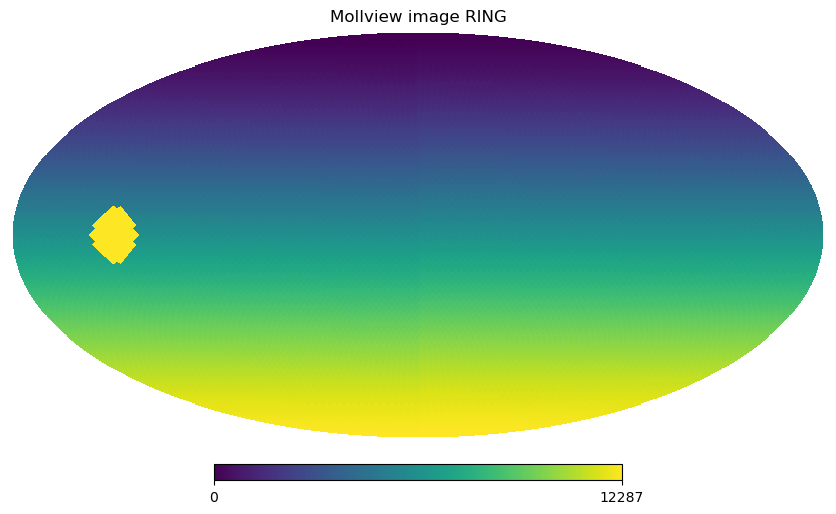

In [18]:
m = np.arange(NPIX)
m[ipix_disc] = m.max()
hp.mollview(m, title="Mollview image RING")

# Place Random Single Sources

In [123]:
m_strain = np.zeros((F,NPIX)) # frequency, pixel positon
# paint the background evenly across
rr=0 # just one realization
avg_pix_strain = hc_bg[:]/ NPIX # (F,R)
m_strain = np.ones((F,NPIX)) * avg_pix_strain[:,rr,np.newaxis]
print('hc_bg=\n',hc_bg[:,rr], '\nnpix=',NPIX, '\nbgpix strain=\n', (m_strain[:,0]))

# choose random pixels to place single sources, 
pix_ss = np.random.randint(0, NPIX-1, size=F*L).reshape(F,L)
print(pix_ss.shape)

# and add the ss_strains to their pixels
for ff in range(F):
    for ll in range(L):
        m_strain[ff,pix_ss[ff,ll]] += hc_ss[ff,rr,ll]

hc_bg=
 [6.44428866e-15 2.65333625e-15 1.49275896e-15 9.62376822e-16
 6.71530089e-16 4.98480630e-16 3.83730381e-16 3.03405349e-16
 2.49254740e-16 2.04945152e-16 1.71143461e-16 1.46510982e-16
 1.26476733e-16 1.09406266e-16 9.64315405e-17 8.54933421e-17
 7.67595641e-17 6.82751871e-17 6.15378831e-17 5.63888372e-17
 5.10053029e-17 4.70439738e-17 4.29037539e-17 3.96045961e-17
 3.67496008e-17 3.38619106e-17 3.12793676e-17 2.94341775e-17
 2.73769460e-17 2.56184751e-17 2.39968617e-17 2.28250949e-17
 2.11846881e-17 2.00098918e-17 1.89299610e-17 1.79305143e-17
 1.69633133e-17 1.60192478e-17 1.53730969e-17 1.46059369e-17] 
npix= 12288 
bgpix strain=
 [5.24437553e-19 2.15929057e-19 1.21481035e-19 7.83184263e-20
 5.46492586e-20 4.05664575e-20 3.12280584e-20 2.46911905e-20
 2.02844027e-20 1.66784791e-20 1.39276905e-20 1.19230942e-20
 1.02927029e-20 8.90350474e-21 7.84761885e-21 6.95746599e-21
 6.24670932e-21 5.55624895e-21 5.00796575e-21 4.58893532e-21
 4.15082218e-21 3.82844839e-21 3.49151643e-21 3

In [ ]:
min_at_freq = np.min(m_strain, axis=1, )
max_at_freq = 

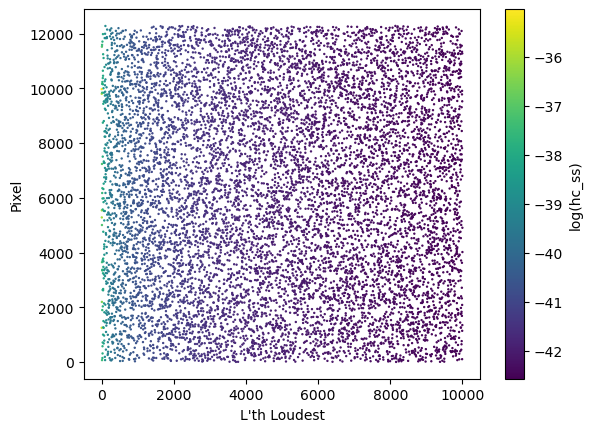

In [157]:
# show in skymap
# ff=23
def ff_mollview(hc_ss, pix_ss, m_strain, ff, plot=False, saveloc=None, ax=None):
    # print(hc_ss[ff,rr,:])
    if plot:
        plt.scatter(np.arange(len(hc_ss[ff,rr,:])), pix_ss[ff,:], c=np.log(hc_ss[ff,rr,:]), cmap='viridis', s=0.5)
        plt.colorbar(label='log(hc_ss)')
        plt.xlabel("L'th Loudest")
        plt.ylabel('Pixel')
    if ax is not None:
        plt.axes(ax)
    hp.mollview(m_strain[ff], title='%d Loudest Single Sources at %.2f yr$^{-1}$ (freq bin %d/%d)' % (L, fobs[ff]*YR, ff, F))
    if saveloc is not None:
        fname = saveloc+'hp_ff%02d.png' % ff
        print(fname)
        plt.savefig(fname, dpi=300)
    plt.close()
fig = ff_mollview(hc_ss, pix_ss, m_strain, 23, plot=True)


In [156]:
saveloc = '/Users/emigardiner/GWs/holodeck/ecg-notebooks/healpix/2023-05-11_sam02_l10000/'
for ff in range(F):
    fig = ff_mollview(hc_ss, pix_ss, m_strain, ff, saveloc=saveloc)
    # fig.savefig(saveloc+'hp_ff%02d.png' % ff, dpi=300)
    # plt.close(fig)

/Users/emigardiner/GWs/holodeck/ecg-notebooks/healpix/2023-05-11_sam02_l10000/hp_ff00.png
/Users/emigardiner/GWs/holodeck/ecg-notebooks/healpix/2023-05-11_sam02_l10000/hp_ff01.png
/Users/emigardiner/GWs/holodeck/ecg-notebooks/healpix/2023-05-11_sam02_l10000/hp_ff02.png
/Users/emigardiner/GWs/holodeck/ecg-notebooks/healpix/2023-05-11_sam02_l10000/hp_ff03.png
/Users/emigardiner/GWs/holodeck/ecg-notebooks/healpix/2023-05-11_sam02_l10000/hp_ff04.png
/Users/emigardiner/GWs/holodeck/ecg-notebooks/healpix/2023-05-11_sam02_l10000/hp_ff05.png
/Users/emigardiner/GWs/holodeck/ecg-notebooks/healpix/2023-05-11_sam02_l10000/hp_ff06.png
/Users/emigardiner/GWs/holodeck/ecg-notebooks/healpix/2023-05-11_sam02_l10000/hp_ff07.png
/Users/emigardiner/GWs/holodeck/ecg-notebooks/healpix/2023-05-11_sam02_l10000/hp_ff08.png
/Users/emigardiner/GWs/holodeck/ecg-notebooks/healpix/2023-05-11_sam02_l10000/hp_ff09.png
/Users/emigardiner/GWs/holodeck/ecg-notebooks/healpix/2023-05-11_sam02_l10000/hp_ff10.png
/Users/emi

## Per Frequency Skymaps

ValueError: The Axes must have been created in the present figure

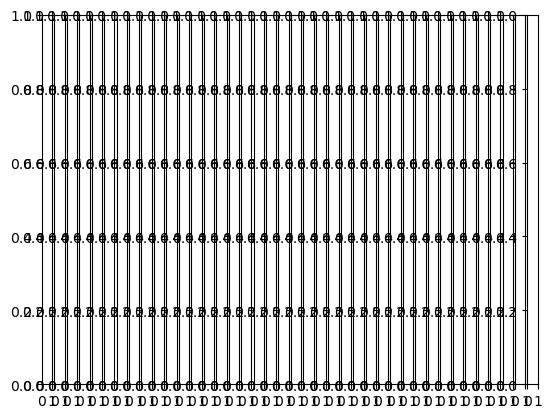

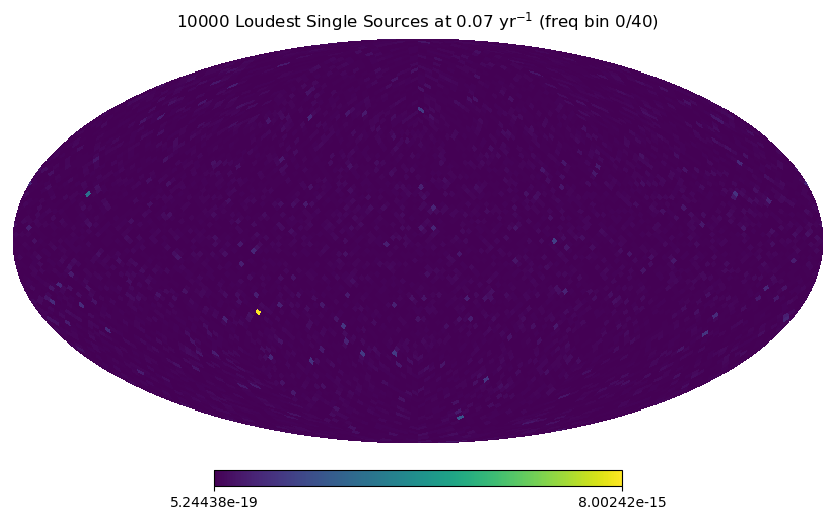

In [158]:
fig, axs = plt.subplots(nrows=1, ncols=int(F))
ff=0
for i, ax in enumerate((axs)):
    plt.axes(ax)
    hp.mollview(m_strain[i], title='%d Loudest Single Sources at %.2f yr$^{-1}$ (freq bin %d/%d)' % (L, fobs[ff]*YR, ff, F))
    # ff+=1

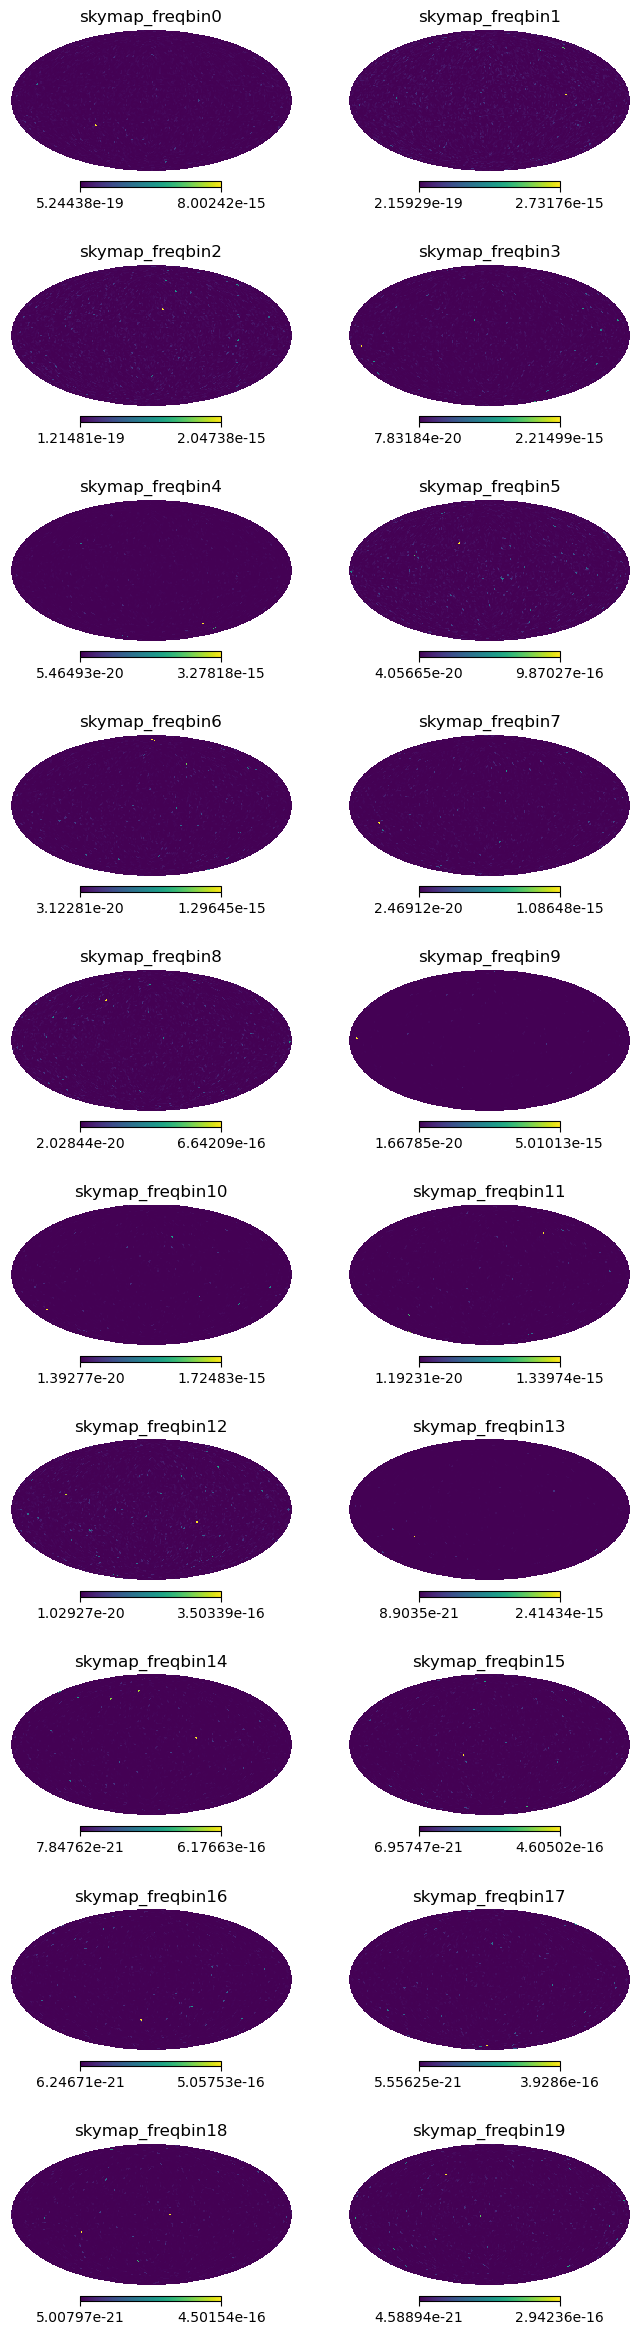

In [150]:
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5), (ax6, ax7), (ax8, 
      ax9), (ax10, ax11), (ax12, ax13), (ax14, ax15), (ax16, 
      ax17), (ax18, ax19)) = plt.subplots(nrows=10, ncols=2)

ax_list = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, 
      ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16, 
      ax17, ax18, ax19]

for i, a in enumerate(ax_list):
    plt.axes(a)
    hp.mollview(m_strain[i], title="skymap_freqbin{}".format(i), hold=True)
fig.set_size_inches(8, 30)